# Tarea semana 2: Entendimiento de los datos con PySpark

## Configuración e importe de paquetes

In [23]:
from pyspark.sql import SparkSession
from pyspark.sql import functions
from pyspark.sql.types import StructType
from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql.types import FloatType, StringType, IntegerType, DateType
from pyspark.sql.functions import udf, col, length, isnan, when, count, to_date, year, max as spark_max, min as spark_min, sum as spark_sum
import pyspark.sql.functions as f
import os 
from datetime import datetime
from pyspark.sql import types as t
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Configuración del controlador e inicio de sesion Spark

In [2]:
path_jar_driver = 'C:\Program Files (x86)\MySQL\Connector J 8.0\mysql-connector-java-8.0.28.jar'

In [3]:
#Configuración de la sesión
conf=SparkConf() \
    .set('spark.driver.extraClassPath', path_jar_driver)

spark_context = SparkContext(conf=conf)
sql_context = SQLContext(spark_context)
spark = sql_context.sparkSession

C:\Users\estudiante\anaconda3\envs\Tutoriales\lib\site-packages\pyspark\sql\context.py:79: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  FutureWarning


In [4]:
# Si quiere practicar la conexion con el servidor de base de datos:
db_connection_string = 'jdbc:mysql://157.253.236.120:8080/WWImportersTransactional'
# El usuario es su estudiante _i asignado y su contraseña la encontrará en el archivo excel de Coursera 
db_user = 'Estudiante_1_202413'
db_psswd = 'aabb1122'

PATH='./'

## Perfilamiento de los datos

#### Conexión a fuente de datos

In [5]:
def obtener_dataframe_de_bd(db_connection_string, sql, db_user, db_psswd):
    df_bd = spark.read.format('jdbc')\
        .option('url', db_connection_string) \
        .option('dbtable', sql) \
        .option('user', db_user) \
        .option('password', db_psswd) \
        .option('driver', 'com.mysql.cj.jdbc.Driver') \
        .load()
    return df_bd

#### Cargue de datos

In [6]:
sql_movimientos = 'WWImportersTransactional.movimientosCopia'

In [7]:
#Se cargan los dataframes desde la base de datos
movimientos = obtener_dataframe_de_bd(db_connection_string, sql_movimientos, db_user, db_psswd)

### Entendimiento general de datos

In [8]:
movimientos.show(5)

+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|               118903|       217|               10|    476.0|  24904.0|           |               |     Apr 25,2014|   -40.0|
|               286890|       135|               10|     33.0|  60117.0|           |               |     Dec 10,2015|    -7.0|
|               285233|       111|               10|    180.0|  59768.0|           |               |     Dec 04,2015|    -2.0|
|               290145|       213|               10|     33.0|  60795.0|           |               |     Dec 23,2015|    -3.0|
|               247492|        90|               10|     55.0|  51851.0|           |               |     Jul 27

Como puede observar en la tabla de movimientos tenemos información **relacionada con el movimiento de inventario de un producto, ya sea por que un cliente lo compro o se le compro a un proveedor**. La información del cliente es su identificador <i>ClienteID</i>, la informacion del proveedor es su identificador <i>ProveedorID</i>, el identificador de la transaccion es <i>TransaccionProductoID</i>, el identificador del producto es <i>ProductoID</i>, el tipo de transaccion es <i>TipoTransaccionID</i>, el identificador de la factura es <i>InvoiceID</i>, el numero de orden de compra es <i>OrdenDeCompraID</i>, le fecha en la que se realizo el movimiento es <i>FechaTransaccion</i> y la cantidad de producto retirado o ingresado al inventario es <i>Cantidad</i>.
A continuacion observaremos los tipos de datos para cada variable.

In [9]:
movimientos.schema

StructType(List(StructField(TransaccionProductoID,IntegerType,true),StructField(ProductoID,IntegerType,true),StructField(TipoTransaccionID,IntegerType,true),StructField(ClienteID,DoubleType,true),StructField(InvoiceID,DoubleType,true),StructField(ProveedorID,StringType,true),StructField(OrdenDeCompraID,StringType,true),StructField(FechaTransaccion,StringType,true),StructField(Cantidad,DoubleType,true)))

Con estos análisis podemos concluir que una fila de movimientos corresponde al ingreso o salida de inventario de un producto especifico identificado por su ProductoID. El ingreso de inventario estara asociado con la compra de inventario a un proveedor, mientras que la salida de inventario estara asociada con le venta de inventario a un cliente.

Ahora vamos vañidar la cantidad de datos disponibles.

In [10]:
print((movimientos.count(), len(movimientos.columns)))

(204292, 9)


**¿Cuantos datos nos compartieron para el proyecto?**
En total tenemos 204.292 movimientos de inventario y tenemos en total 9 variables a revisar de las cuales 6 son nùmericas asociadas a las órdenes, una es de tipo fecha y las demás son cadenas de caracteres. Es importante considerar que el ID deProveedor se definio como texto.

### Revisión de reglas de negocio 

Primero se confirman las reglas proporcionadas por el negocio:
1. La cantidad máxima de productos movidos es 50 millones por transacción. Esta regla no se cumple ya que como se oberva al filtrar por la columna Cantidad valores que sean mayores a 50 millones, no se obtienen resultados. Como podemos evidenciar el maximo valor de la columna Cantidad es de 67368 (valores positivos asociados a ingreso de inventario) y el minimo valor es de -360 (valores negativos asociados a retiro de inventario).

In [28]:
cantidad_filtrada = movimientos.filter(col("Cantidad") >= 50000000)
# Mostrar las filas filtradas
cantidad_filtrada.show()

movimientos.agg(
    spark_max(col("Cantidad")).alias("max_Cantidad"),
    spark_min(col("Cantidad")).alias("min_Cantidad")
).show()


+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
|TransaccionProductoID|ProductoID|TipoTransaccionID|ClienteID|InvoiceID|ProveedorID|OrdenDeCompraID|FechaTransaccion|Cantidad|
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+
+---------------------+----------+-----------------+---------+---------+-----------+---------------+----------------+--------+

+------------+------------+
|max_Cantidad|min_Cantidad|
+------------+------------+
|     67368.0|      -360.0|
+------------+------------+



Adicionalmente suponiendo que pueda existir transacciones con ID repetido, representando un mismo movimiento se agrupa por TransaccionProductoID y se calcula la suma de la columna cantidad. Como se observ, agrupando por TransaccionProductoID el valor maximo de movimientos de entrada es de 133.392 mientras que el valor maximo de movimientos de salida es de -720, valores por debajo de 50 millones por transaccion.

In [33]:
aggupacion_transaccion = movimientos.groupBy("TransaccionProductoID").agg(
    spark_sum("Cantidad").alias("Total_Cantidad"))

aggupacion_transaccion.agg(
    spark_max(col("Total_Cantidad")).alias("max_Cantidad"),
    spark_min(col("Total_Cantidad")).alias("min_Cantidad")
).show()



+------------+------------+
|max_Cantidad|min_Cantidad|
+------------+------------+
|    133392.0|      -720.0|
+------------+------------+



2. Existen 236.668 movimientos de producto realizados desde 2013. Ya que solamente hay 204.292 movimientos en total, esta afirmacion del negocio es falsa, ya queaun filtrando desde el año 2013, el maximo numero de movimientos que podriamos tener es de 204.292.

In [13]:
movimientos.count()

204292

3. Los movimientos están relacionados con 228.265 clientes. Esta afirmacion es falsa ya que solamente hay 204.292 movimientos en total, y aunque cada movimiento fuera realizado por un unico cliente, maximo podrian existir 204.292 clientes. En realidad solamente hay 664 clientes unicos en la tabla de movimientos identificados por el ClienteID.

In [14]:
movimientos.select(col("ClienteID")).distinct().count()

664

4. El formato de fechas manejado es YYYY-MM-DD HH:MM:SS. Esta afirmacion del negocio es falsa, ya que se puede observar que solamente hay 140.038 movimientos cuya fecha maneja el formato YYYY-MM-DD HH:MM:SS. Quedan 64.254 movimientos que el formato de fecha no es YYYY-MM-DD HH:MM:SS. 

In [15]:
regex = "[0-2]\d{3}-(0[1-9]|1[0-2])-(0[1-9]|[1-2][0-9]|3[0-1])"
cumplenFormato = movimientos.filter(movimientos["FechaTransaccion"].rlike(regex))
print("Número total de ordenes: "+str(movimientos.count())+", número de ordenes con formato correcto: "+str(cumplenFormato.count()))

Número total de ordenes: 204292, número de ordenes con formato correcto: 140038


In [16]:
noCumplenFormato = movimientos.filter(~movimientos["FechaTransaccion"].rlike(regex))
noCumplenFormato.count(), noCumplenFormato.select(col("FechaTransaccion")).show()

+----------------+
|FechaTransaccion|
+----------------+
|     Apr 25,2014|
|     Dec 10,2015|
|     Dec 04,2015|
|     Dec 23,2015|
|     Jul 27,2015|
|     Sep 15,2014|
|     Aug 04,2015|
|     Feb 23,2015|
|     May 01,2015|
|     Jan 08,2016|
|     Mar 26,2014|
|     Jul 31,2015|
|     Sep 02,2014|
|     Mar 15,2016|
|     May 28,2016|
|     Sep 09,2015|
|     May 23,2014|
|     Aug 20,2014|
|     Jan 21,2015|
|     Dec 29,2015|
+----------------+
only showing top 20 rows



(64254, None)

5. Actualmente tenemos 13 proveedores. Esta afirmacion del negocioes falsa pues solo se observan movimientos con tres proveedores (ProvedoID 1, 4 y 7). Aunque en la tabla a continuacin se observa un registro vacio, este corresponde a los movimientos de clientes para los cuales el valor de ProveedorID no existe.

In [17]:
print(movimientos.select(col("ProveedorID")).distinct().count())
movimientos.select(col("ProveedorID")).distinct().show()

4
+-----------+
|ProveedorID|
+-----------+
|        1.0|
|        4.0|
|        7.0|
|           |
+-----------+



### Análisis descriptivo

In [ ]:
descriptivo = movimientos.summary().toPandas()
descriptivo

,summary,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,ProveedorID,OrdenDeCompraID,FechaTransaccion,Cantidad
0,count,204292,204292,204292,204292,204292,204292,204292,204292,204292
1,mean,212458.04047637695,110.70090850351458,10.035253460732676,517.3252941867523,42957.26929590978,4.951898734177215,1345.9973277074544,None,719.4997650421946
2,stddev,71352.37579752573,63.49014746219581,0.18563716955046372,353.50136995999276,16826.9772221931,1.406311225432683,420.37740964792835,None,4729.36659747762
3,min,89146,1,10,0.0,0.0,,,2013-12-31 07:00:00.0000000,-360.0
4,25%,150639,56,10,145.0,30120.0,4.0,986.0,None,-60.0
5,50%,212323,110,10,511.0,43546.0,4.0,1347.0,None,-9.0
6,75%,274216,166,10,877.0,56983.0,7.0,1710.0,None,-5.0
7,max,336251,227,12,1061.0,70510.0,7.0,999.0,"Sep 30,2015",67368.0


En las estadísticas anteriores vemos que todas las columnas tienen el mismo numero de valores, es decir 204.292, es decir que no hay columnas vacias, sin embargo es importe aclarar que si se observan columnas que tienen valores faltantes, como es el caso de ClienteID y ProveedorID, puesto que tienen valores vacios diferentes a null o None representando la ausencia de datos (Se ovserva el valor ''). También observamos el calculo de la media para la columna Cantidad, la cual tiene un valor de 719.4 y una desviacion estandar de 4729.3, tambien se observa el percentil 75% de la columna  Cantidad que indica que el 75% de los movimientos esta por debajo de - 5, se debe considerar que esto indica retiro de inventario de un producto relacionado con la compra de un cliente, adicionalmente podemos ver para la columna Cantidad que el minimo movimiento es de -360 y el maximo es de 67368, se debe tener especial cuidado con la interpretacion de estos valores ya que el valor negativo indica unicamente salida del inventario. Para la columna de FechaTransaccion se calcula el minimo y el maximo, sin embargo debe tenerse cuidado en esta informacion pues ya vimos que los formatos de los valores de esta columna son diferentes, lo que afecta la comparacion. 
Para las columnas TransaccionProductoID, ProductoID, TipoTransaccion ID, ClienteID, InvoiceID, ProveedorID y OrdenDeCompraID aunque se calcula valores descriptivos, para el ejercicio y entendiendo el significado de las variables no hace sentido su interpretacion directamente de la tabla anterior.

{'whiskers': [<matplotlib.lines.Line2D at 0x2623b0fdc88>,
 'caps': [<matplotlib.lines.Line2D at 0x2623b0fd348>,
 'boxes': [<matplotlib.lines.Line2D at 0x2623b12a408>],
 'medians': [<matplotlib.lines.Line2D at 0x26235dff248>],
 'fliers': [<matplotlib.lines.Line2D at 0x2623b0fd488>],
 'means': []}

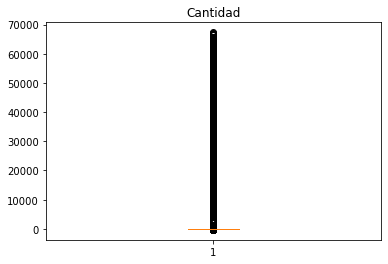

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt

fig1, ax1 = plt.subplots()
ax1.set_title('Cantidad')
ax1.boxplot(np.array(movimientos.select('Cantidad').collect()))

En el grafico boxplot anterior podemos observar para la columna Cantidad valores atipicos que llegan hasta cerca de los 70000.

En las tablas a continuacion podemos evidenciar la moda para la columna Proveedor ID y Cliente ID. Esto nos mostraria por un lado el proveedor con el que mas movimientos de inventario se hacen, en este caso el proveedor 4, con 4.832 movimientos ((El ProveedorID sin ID corresponde a los movimientos de clientes y no un movimiento de un cliente sin ID)). La segunda tabla nos muestra el cliente que mas movimientos realiza, es decir el cliente 980 con 409 movimientos de inventario (El ClienteID con ID 0 corresponde a los movimientos de proveedores y no un movimiento de un cliente con ID 0).  

In [ ]:
movimientos.groupby("ProveedorID").count().orderBy("count", ascending=False).show(5)

+-----------+------+
|ProveedorID| count|
+-----------+------+
|           |197182|
|        4.0|  4832|
|        7.0|  2267|
|        1.0|    11|
+-----------+------+



In [21]:
movimientos.groupby("ClienteID").count().orderBy("count", ascending=False).show(5)

+---------+-----+
|ClienteID|count|
+---------+-----+
|      0.0| 7156|
|    980.0|  409|
|    810.0|  401|
|    804.0|  395|
|    149.0|  395|
+---------+-----+
only showing top 5 rows



En el siguiente cuadro observamos la moda de la columna ProductID, indicandonos el producto con mas movimientos en el inventario, en este caso el prodcuto con ID 80. Es importante considerar que en esta tabla no se observa la cantidad de producto retirado o ingresado a stock, solo es un conteo de las filas para cada ID de producto.

In [22]:
movimientos.groupby("ProductoID").count().orderBy("count", ascending=False).show(5)
movimientos.groupby("ProductoID").count()

+----------+-----+
|ProductoID|count|
+----------+-----+
|        80| 1488|
|        95| 1477|
|       184| 1339|
|        86| 1318|
|       193| 1312|
+----------+-----+
only showing top 5 rows



DataFrame[ProductoID: int, count: bigint]

## Análisis de calidad de datos

A continuación se definen dos funciones, la primera cuenta los valores vacios por columna de dataframe, la segunda retorna un diccionario de columnas con cardinalidad superior al 50%

Te invito a revisar los recursos de calidad de datos que hemos visto en el curso, a continuacion ejemplos daremos algunos ejemplos por cada dimensión para el caso del tutorial

### Unicidad

A cotinuacion vamos a revisar la unicidad para cada una de las columnas de nuestro dataframe. Aunque desde la perspectiva de entendimiento de datos hay columnas que pueden tener valores repetidos, por ejemplo ProductoID, considerando que diferentes clientes pueden generar movimeintos del mismo ProductoID, es importante identificar cuales columnas no deberian tener valores repetidos, por ejemplo si consideramos la columna TransaccionProductoID que identifica la transaccion, no deberia existir un valor deplicado. Sin embargo evidenciamos que esta columna tiene valores duplicados.Para las otras columnas el analisis seria:

    TipoTransaccionID: Podria tener valores duplicados ya que refleja entrada y salida de productos del inventario.
    ClienteID: Puede tener valores repetido si se considera que un mismo cliente puede comprar diferentes productos.
    InvoiceID: Puede tener valores repetidos si refleja un cliente o proveedor realizando movimiento de inventario. 
    OrdenDeCompraID: Una orden de compra podria estar atada a un mismo proveedor el cualabastece con diferentes productos a la empresa.
Estos supuestos deben validarse con el negocio para corroborar que efectivamente sea valido la existencia de duplicados en estas columnas.

In [23]:
columnas = movimientos.columns

for columna in columnas:
    conteo_distintos = movimientos.select(columna).distinct().count()
    if conteo_distintos == movimientos.count():
        print(f"La columna '{columna}' es única en todo el DataFrame.")
    else:
        print(f"La columna '{columna}' no es única en todo el DataFrame.")


La columna 'TransaccionProductoID' no es única en todo el DataFrame.
La columna 'ProductoID' no es única en todo el DataFrame.
La columna 'TipoTransaccionID' no es única en todo el DataFrame.
La columna 'ClienteID' no es única en todo el DataFrame.
La columna 'InvoiceID' no es única en todo el DataFrame.
La columna 'ProveedorID' no es única en todo el DataFrame.
La columna 'OrdenDeCompraID' no es única en todo el DataFrame.
La columna 'FechaTransaccion' no es única en todo el DataFrame.
La columna 'Cantidad' no es única en todo el DataFrame.


A modeo de ejemplo se filtra por la columna TransaccionProductoID un valor que se identifico como duplicado (ID 200379). Como se evidencia las dos filas que aparecen tienen exactamente los mismos valores para todas las columnas.

In [24]:
duplicado = movimientos.filter(col("TransaccionProductoID") == 200379).toPandas()
duplicado

,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,ProveedorID,OrdenDeCompraID,FechaTransaccion,Cantidad
0,200379,25,10,484.0,41953.0,,,2015-02-21 12:00:00.0000000,-8.0
1,200379,25,10,484.0,41953.0,,,2015-02-21 12:00:00.0000000,-8.0


En conclusion ninguna columna tiene todos sus valores unicos. Debe confirmarse con el negocio si los supuestos de que el TransaccionProductoID no debe tener duplicados es correcto, asi como las suposiciones para las otras columnas.

### Validez

In [25]:
movimientos.printSchema()


root
 |-- TransaccionProductoID: integer (nullable = true)
 |-- ProductoID: integer (nullable = true)
 |-- TipoTransaccionID: integer (nullable = true)
 |-- ClienteID: double (nullable = true)
 |-- InvoiceID: double (nullable = true)
 |-- ProveedorID: string (nullable = true)
 |-- OrdenDeCompraID: string (nullable = true)
 |-- FechaTransaccion: string (nullable = true)
 |-- Cantidad: double (nullable = true)



Podemos observar que la columna FechaTransaccion esta con formato String, siendo un fecha. De igual forma el ProveedorId esta definido como un string, siendo un numero el que lo identifica. Para la columna de OrdenDeCompraID se define como un string, siendo igualmente un numero. Finalmente la Columna cantidad tiene un valor double, que podria aceptar numeros decimales, sin embargo esto solo tendria sentido en el caso que se puedan adquirir porciones de un producto.

Adicionalmente en las reglas de negocio validamos que el formato de la fecha no es el esperado, obteniendo 64.254 movimientos que el formato de fecha no es YYYY-MM-DD HH:MM:SS. 

En conclusion existe problemas de validez de los datos, por un lado en la definicion del tipo de dato para las columnas InvoiceID, ProveedorID, OrdenDeCompraID, FechaTransaccion y Cantidad.

### Completitud

In [26]:
def contar_vacios(df):
    resultados = []
    for c in df.columns:
        # Contar valores nulos y cadenas vacías ('')
        vacios = df.filter((df[c].isNull()) | (df[c] == '')).count()
        if vacios != 0:
            print('Número de vacíos para columna ' + c + ': ' + str(vacios))
            resultados.append(vacios)
        else:
            print('Número de vacíos para columna ' + c + ': ' + "es cero")
    return resultados

def cardinalidad(df):
    resultado = {}
    for c in df.columns:
        cardinalidad = df.select(col(c)).distinct().count()
        if cardinalidad>=df.count()*0.5:
            resultado[c] = cardinalidad
    return resultado

In [27]:
columnas_vacias_ordenes = contar_vacios(movimientos)

Número de vacíos para columna TransaccionProductoID: es cero
Número de vacíos para columna ProductoID: es cero
Número de vacíos para columna TipoTransaccionID: es cero
Número de vacíos para columna ClienteID: es cero
Número de vacíos para columna InvoiceID: es cero
Número de vacíos para columna ProveedorID: 197182
Número de vacíos para columna OrdenDeCompraID: 197182
Número de vacíos para columna FechaTransaccion: es cero
Número de vacíos para columna Cantidad: es cero


In [28]:
columnas_alta = cardinalidad(movimientos)
columnas_alta

{'TransaccionProductoID': 173659}

Como se evidencia hay columnas que tienen valores faltantes ProveedorID y OrdenDeCompraID. Si se analiza el DataFrame, se evidencian columnas que tienen valores que parecen faltantes como el de ProveedorID, sin embargo en un analissi mas detallado se identifica que este valor corresponde a la designacion de ausencia con un valor tipo string de "". Aunque tener valores faltantes en este modo puede afectar el analisis, debe considerarse transformarlos a valores Null o None para representar la ausencia de valor. Para la logica de la columna de ProveedorID, es valido tener un valor faltante en este caso ya que cuando el movimiento lo hace un cliente y no un proveedor, es normal que no tenga valor. En el caso de ClienteID pasa algo similar pero se identifica con 0 el caso donde se tiene un movimiento de proveedor, que por ende no tendra un ID de cliente.

En conclusion podemos decir que  hay datos faltantes pero debe validarse con el negocio si las suposiciones son correctas, ya que la ausencia de estos valores es congruente con la logica del negocio, y finalmente decidir transformar el dataframe con valores de Null o None para representar la ausencia de un valor.

### Consistencia
Anivel de consistencia podemos ver consistencia semantica en la descripcion de las columnas con los valores alamcenados en las mismas, ya que reflejan de forma correcta el contenido que se espera de estas columnas. 

Por otro lado evidenciamos en el analis de unicidad que no hay una consistencia para reflejar valores faltantes, por lo que es necesario poder estandarizar est ausencia de datos para simplificar el analisis y tener claridad de la interpretacion de los datos.

## Entendimiento de los datos adicional

A continuacion se crea una tabla pivote para ver cuantos movimientos hay por ProductID y por ProveedorID. E simportante considerar que aca tambien se observa los movimientos de los clientes representados por el ProductID ''. 

In [29]:
movimientos.groupBy('ProductoID').pivot('ProveedorID').count().show()

+----------+---+----+----+----+
|ProductoID|   | 1.0| 4.0| 7.0|
+----------+---+----+----+----+
|       148|920|null|null|null|
|        31|917|null|null|null|
|       137|946|null|null|null|
|        85|915|null|null|null|
|        65|955|null|null|null|
|        53|916|null|null|null|
|       133|914|null|null|null|
|        78|473|null| 823|null|
|       108|930|null|null|null|
|       155|877|null|null|null|
|       211|884|null|null|null|
|       193|508|null|null| 804|
|        34|928|null|null|null|
|       115|900|null|null|null|
|       101|944|null|null|null|
|       126|868|null|null|null|
|        81|896|null|null|null|
|       210|851|null|null|null|
|        28|933|null|null|null|
|       183|909|null|null|null|
+----------+---+----+----+----+
only showing top 20 rows



Acontinuacion se hace un analisis de correlaciones pero es importante considerar que estas relaciones no tienen un sentido logico implicito. Por ejemplo la variable InvoiceID con TransaccionProductID aparece con una correlacion alta (0.8) pero son dos variables que se no tienen aparentemente una relacion lgoica dentro del proceso de movimientos.

In [30]:
corr = movimientos.toPandas().corr(method='pearson')
corr.style.background_gradient(cmap='coolwarm')

,TransaccionProductoID,ProductoID,TipoTransaccionID,ClienteID,InvoiceID,Cantidad
TransaccionProductoID,1.000000,0.017905,-0.001819,0.021868,0.859235,0.060616
ProductoID,0.017905,1.000000,0.028463,-0.009326,0.001007,0.028805
TipoTransaccionID,-0.001819,0.028463,1.000000,-0.277915,-0.484808,0.833650
ClienteID,0.021868,-0.009326,-0.277915,1.000000,0.154670,-0.234709
InvoiceID,0.859235,0.001007,-0.484808,0.154670,1.000000,-0.409633
Cantidad,0.060616,0.028805,0.833650,-0.234709,-0.409633,1.000000


## Conclusiones/resultados

**Conclusiones generales:**

1. En la tabla de movimientosCopia tenemos información **relacionada con el movimiento de inventario de un producto, ya sea por que un cliente lo compro o se le compro a un proveedor**
2. Una fila de movimientos representa la entrada o salida de inventario de un producto especifico. Las entradas de inventario correspon a movimientos de proveedores, mientras que las salidas de inventario corresponden a movimientos de clientes. Puede existir casos distintos dentro del proceso de la compañia? Ejemplo, regresar inventario a un proveedor? La devolucion de un producto por parte de un cliente?
3. La tabla de movimientosCopia tiene 204292 filas y  columnas 9.

**Conclusiones de reglas de negocio:**

1. La regla 1 no es cierta, ya que se observa que el maximo valor de la columna Cantidad es de 67368. Este calculo de 50 millones es correcto? Deben considerarse una transaccion como la union de varias filas de la base de datos, o una transaccion corresponde unicamente a una fila?
2. La regla 2 no es cierta, el maximo numero de movimientos que podriamos tener es de 204.292, acorde con el tamaño de la tabla movimientosCopia. Es posible que falte datos historicos en la informacion compartida?
3. La regla 3 es falsa, solamente hay 664 clientes unicos en la tabla de movimientos identificados por el ClienteID. Adicionalmente la tabla movimientosCopia solo tiene 204.292 registros. Es correcto considerar que un cliente unico se identifica por el ID ClienteID?
4. Algunos formatos de fecha no coinciden con el dado en la regla 4, quedan 64.254 movimientos que el formato de fecha no es YYYY-MM-DD HH:MM:SS. En este caso el cambio de formato se puede implementar, ¿estan de acuerdo?
5. La regla 5 es falsa,  pues solo se observan movimientos con tres proveedores (ProvedoID 1, 4 y 7). Es correcto identificar a cada proveedor por el ID proveedorID?

**Conclusiones de calidad:**

1. Ninguna columna contiene valores únicos. Es necesario confirmar  si la suposición de que la columna TransaccionProductoID no debe tener duplicados es correcta, así como verificar:

    TipoTransaccionID: Podria tener valores duplicados ya que refleja entrada y salida de productos del inventario.
    
    ClienteID: Puede tener valores repetido si se considera que un mismo cliente puede comprar diferentes productos.
    
    InvoiceID: Puede tener valores repetidos si refleja un cliente o proveedor realizando movimiento de inventario. 
    
    OrdenDeCompraID: Una orden de compra podria estar atada a un mismo proveedor el cualabastece con diferentes productos a la empresa.
2. Existe problemas de validez de los datos, por un lado en la definicion del tipo de dato para las columnas InvoiceID, ProveedorID, OrdenDeCompraID, FechaTransaccion y Cantidad no reflejan el tipo de datos que se esta almacenando. Esto afecta el analisis yno refleja la naturaleza de los datos alamcenados. Podemos redefinir los tipos de datos para reflejar mayo congruencia con los datos, estan de acuero?
3. Hay datos faltantes pero debe validarse si las suposiciones son correctas, ya que la ausencia de estos valores es congruente con la logica del negocio, y finalmente decidir transformar el dataframe con valores de Null o None para representar la ausencia de un valor.
Suposicion:
La columna ProveedorID tiene como valor faltante "". En el contexto de ProveedorID, es aceptable tener valores faltantes, ya que es común que los movimientos realizados por clientes no tengan un proveedor asociado. Para ClienteID, se utiliza 0 cuando el movimiento es realizado por un proveedor sin un ID de cliente asociado.Es correcto este planteamiento? Podemos convertir los valores faltantes en ull o None, estan de acuerdo?
4. Respecto a cardinalidad, solo la columna TransaccionProductoID tiene una cardinalidad superior al 50%.


**Sección de correlación:**

1. Hay columnas que tienen una alta correlacion, como lo son InvoiceID con TransaccionProductID, sin embargo se considera que esta correlacion no obedece a una logica de negocio o mercado. 